
    This Source Code Form is subject to the terms of the Mozilla Public
    License, v. 2.0. If a copy of the MPL was not distributed with this
    file, You can obtain one at http://mozilla.org/MPL/2.0/.


In [1]:
# Enable automatic module reload
%load_ext autoreload
%autoreload 2

# Load EPEACS module
from epeacs.agents.epeacs import EPEACS, Configuration

from epeacs.agents.epeacs.utils.Plotting_wrapper import \
    parse_metrics_to_df, \
    plot_performance

from epeacs.metrics import \
    _maze_metrics, \
    _how_many_peps_match_non_aliased_states, \
    _mean_reliable_classifier_specificity, \
    _when_full_knowledge_is_achieved, \
    _state_of_population, \
    _enhanced_effect_error

# Load environments
import gym
import my_mazes

# Agent - EPEACS

## Common parameters

In [2]:
CLASSIFIER_LENGTH = 8
NUMBER_OF_POSSIBLE_ACTIONS = 8

MAZE = "Woods101-v0"

NUMBER_OF_EXPLORE_TRIALS = 5000
METRICS_TRIAL_FREQUENCY_EXPLORE = 10
BETA_ALP = 0.05
BETA_RL = 0.05
BETA_PEP = 0.01
EPSILON = 0.8

DO_GA = True
ENABLE_PEP = True

SLIPPERY_PROB = 0.25

## Environment - Maze

In [3]:
# Initialize environment
maze = gym.make(MAZE)
# Set up probability to do a random action
maze.env.set_prob_slippery(SLIPPERY_PROB)
# Reset it, by putting an agent into random position
maze.reset()
# Render the state in ASCII
maze.render('aliasing_human')


■ ■ ■ ■ ■ ■ ■
■ A ■ □ ■ □ ■
■ □ ■ □ ■ □ ■
■ ■ ■ $ ■ ■ ■
■ ■ ■ ■ ■ ■ ■


## Training of EPEACS - Exploration

In [4]:
%%time

cfg_explore = Configuration(
    classifier_length=CLASSIFIER_LENGTH,
    number_of_possible_actions=NUMBER_OF_POSSIBLE_ACTIONS,
    user_metrics_collector_fcn=_maze_metrics,
    metrics_trial_frequency=METRICS_TRIAL_FREQUENCY_EXPLORE,
    do_pep=ENABLE_PEP,
    do_ga=DO_GA,
    beta_alp=BETA_ALP,
    beta_rl=BETA_RL,
    beta_pep=BETA_PEP,
    gamma=0.95,
    theta_i=0.1,
    theta_r=0.9,
    epsilon=EPSILON,
    u_max=CLASSIFIER_LENGTH,
    theta_exp=20,
    theta_ga=100,
    theta_as=20,
    mu=0.3,
    chi=0.8
)

agent_explore = EPEACS(cfg_explore)
population_explore, metrics_explore = agent_explore.explore(maze, NUMBER_OF_EXPLORE_TRIALS)

CPU times: user 13min 17s, sys: 1.45 s, total: 13min 19s
Wall time: 13min 27s


### Performance

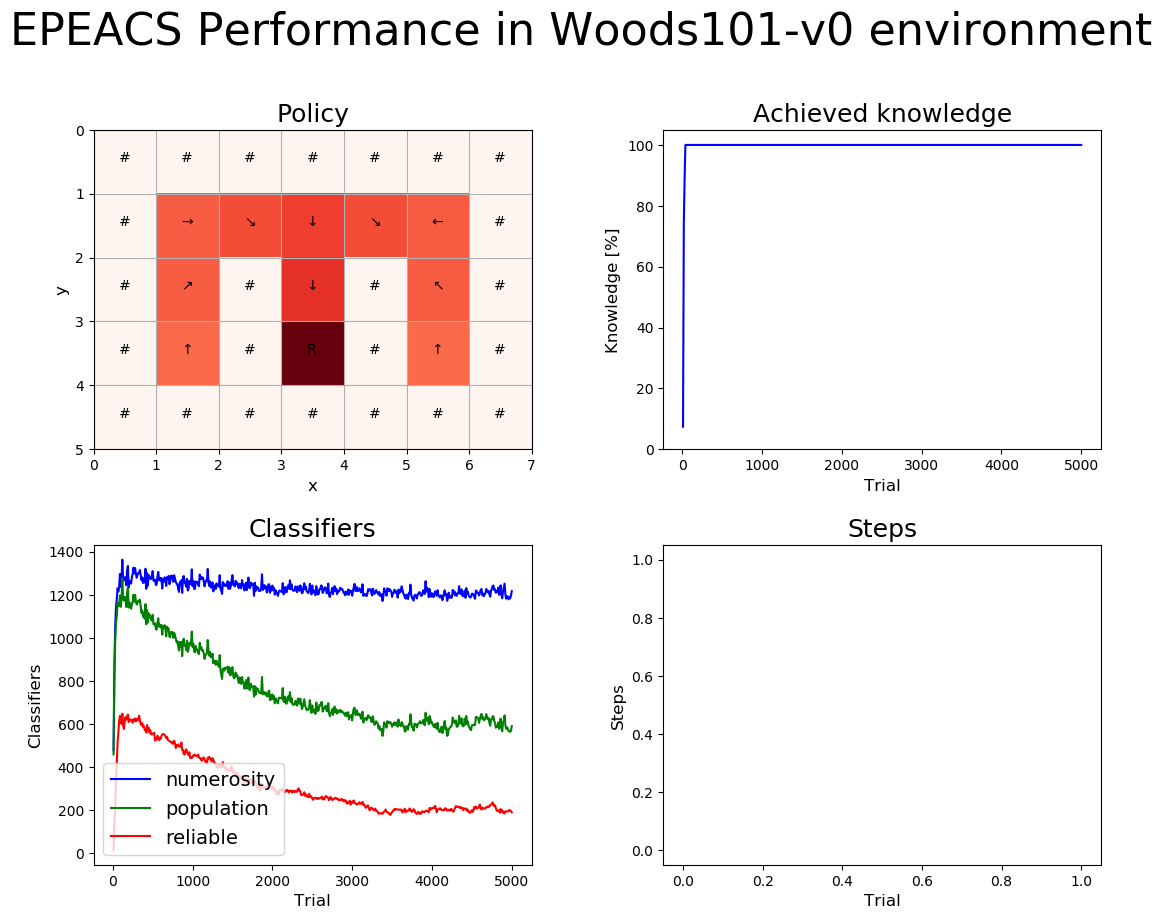

In [5]:
metrics_trial_frequency_explore = cfg_explore.metrics_trial_frequency

metrics_df = parse_metrics_to_df(metrics_explore, metrics_trial_frequency_explore, None, None)
plot_performance(agent_explore, maze, metrics_df, cfg_explore, MAZE, metrics_trial_frequency_explore, None)

In [6]:
print(_maze_metrics(population_explore, maze))

first_trial, stable_trial = _when_full_knowledge_is_achieved(metrics_explore)

print("Full knowledge was achieved at trials ", first_trial, " and was stable at ", stable_trial)

print("There are ", _how_many_peps_match_non_aliased_states(population_explore, maze),
      " enhanced classifer(s) that match a non-aliased states.")

print("Mean reliable population specifity is ",
      _mean_reliable_classifier_specificity(population_explore, maze))

print(_state_of_population(metrics_explore, first_trial, METRICS_TRIAL_FREQUENCY_EXPLORE))

old_error, new_error = _enhanced_effect_error(population_explore, maze)
print("Accumulated Error on PEP Probabilities : old->", old_error, " new->", new_error)

{'knowledge': 100.0, 'population': 590, 'numerosity': 1217, 'reliable': 190}
Full knowledge was achieved at trials  40  and was stable at  40
There are  105  enhanced classifer(s) that match a non-aliased states.
Mean reliable population specifity is  0.7881578947368421
{'trial': 40, 'steps_in_trial': 42, 'reward': 1000, 'knowledge': 100.0, 'population': 1068, 'numerosity': 1142, 'reliable': 341}
Accumulated Error on PEP Probabilities : old-> 11868.561245456644  new-> 768.8242088301978


In [7]:
population_explore.sort(key=lambda cl: -cl.exp)
population_explore_to_display = [(cl.condition, cl.action, cl.effect, cl.exp, cl.mark) for cl in population_explore
    if cl.is_reliable() and cl.is_enhanced()]
for cl in population_explore_to_display:
    print(cl)
    print(cl[2].print_detailled_counter())
    print("\n")

(0#119110, 4, {0:76.52% (90.70%4918), 1:23.48% (9.30%504)}{1:74.74% (87.27%4732), 0:25.26% (12.73%690)}{1:76.52% (90.70%4918), 0:23.48% (9.30%504)}{1:80.20% (93.58%5074), 0:19.80% (6.42%348)}{1:70.73% (84.40%4576), 9:22.25% (12.73%690), 0:7.02% (2.88%156)}{1:80.20% (93.58%5074), 0:19.80% (6.42%348)}{1:76.52% (90.70%4918), 0:23.48% (9.30%504)}{1:74.74% (87.27%4732), 0:25.26% (12.73%690)}, 5420, empty)
00119110:#689, 11001001:#347, 01111111:#4228, 11010101:#155


(1#010101, 4, {0:63.78% (77.01%3481), 1:36.22% (22.99%1039)}{0:63.78% (77.01%3481), 1:36.22% (22.99%1039)}{1:63.78% (77.01%3481), 0:36.22% (22.99%1039)}{1:78.49% (93.67%4233), 0:21.51% (6.33%286)}{9:60.96% (77.01%3481), 0:26.44% (16.66%753), 1:12.59% (6.33%286)}{1:78.49% (93.67%4233), 0:21.51% (6.33%286)}{1:63.78% (77.01%3481), 0:36.22% (22.99%1039)}{0:63.78% (77.01%3481), 1:36.22% (22.99%1039)}, 4518, empty)
00119110:#3480, 11010101:#752, 11001001:#285


(1#00100#, 4, {1:77.98% (93.37%4085), 0:22.02% (6.63%290)}{1:79.46% (94.99

In [8]:
#délétion des classeurs à revoir en prenant en compte cl.num et cas particulier de most_experienced_classifier=NULL

#{'knowledge': 100.0, 'population': 1413, 'numerosity': 2527, 'reliable': 412}
#Full knowledge was achieved at trials  1050  and was stable at  9890
#Mean reliable population specifity is  0.8243325242718447
#Accumulated Error on PEP Probabilities : old-> 15735.932750922777  new-> 1846.9932345105583

#{'knowledge': 100.0, 'population': 1297, 'numerosity': 2461, 'reliable': 427}
#Full knowledge was achieved at trials  1200  and was stable at  9360
#Mean reliable population specifity is  0.7295081967213115
#Accumulated Error on PEP Probabilities : old-> 16710.39938562711  new-> 1902.8960635584824

#{'knowledge': 100.0, 'population': 1274, 'numerosity': 2470, 'reliable': 434}
#Full knowledge was achieved at trials  970  and was stable at  9700
#Mean reliable population specifity is  0.7410714285714286
#Accumulated Error on PEP Probabilities : old-> 17270.11944611326  new-> 2079.404324407646